In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import os, shutil

original_dataset_dir = './datasets/dogs-vs-cats/train'
new_dataset_dir = './datasets/small-dvc'

if not os.path.isdir(new_dataset_dir):
    os.mkdir(new_dataset_dir)

train_dir = os.path.join(new_dataset_dir, 'train')
validation_dir = os.path.join(new_dataset_dir, 'validation')
test_dir = os.path.join(new_dataset_dir, 'test')

for directory in [train_dir, validation_dir, test_dir]:
    if not os.path.isdir(directory):
        os.mkdir(directory)

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

for directory in [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir, test_cats_dir, test_dogs_dir]:
    if not os.path.isdir(directory):
        os.mkdir(directory)

for loc, start, end in [("train", 0, 1000), ("validation", 1000, 1500), ("test", 1500, 2000)]:
    for animal in ["cat", "dog"]:
        fnames = [f"{animal}.{i}.jpg" for  i in range(start, end)]
        for fname in fnames:
            src = f"{original_dataset_dir}/{fname}"
            dst = f"{new_dataset_dir}/{loc}/{animal}s/{fname}"
            shutil.copyfile(src, dst)


In [3]:
from keras import models, layers, optimizers

def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["acc"])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
for data_batch, labels_batch in train_generator:
    print(data_batch.shape)
    print(labels_batch.shape)
    break

(20, 150, 150, 3)
(20,)


In [6]:
basic_history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30


/usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 9s 62ms/step - loss: 0.6927 - acc: 0.5178 - val_loss: 0.6809 - val_acc: 0.5930
Epoch 2/30
100/100 [==============================] - 6s 57ms/step - loss: 0.6771 - acc: 0.5779 - val_loss: 0.6582 - val_acc: 0.5930
Epoch 3/30
100/100 [==============================] - 6s 57ms/step - loss: 0.6576 - acc: 0.6208 - val_loss: 0.6979 - val_acc: 0.5240
Epoch 4/30
100/100 [==============================] - 6s 57ms/step - loss: 0.6251 - acc: 0.6482 - val_loss: 0.6054 - val_acc: 0.6580
Epoch 5/30
100/100 [==============================] - 6s 57ms/step - loss: 0.5893 - acc: 0.6762 - val_loss: 0.6392 - val_acc: 0.6400
Epoch 6/30
100/100 [==============================] - 6s 56ms/step - loss: 0.5516 - acc: 0.7045 - val_loss: 0.5738 - val_acc: 0.7060
Epoch 7/30
100/100 [==============================] - 6s 56ms/step - loss: 0.5308 - acc: 0.7470 - val_loss: 0.5792 - val_acc: 0.7000
Epoch 8/30
100/100 [==============================] - 6s 58ms/step - loss: 0.517

In [7]:
model.save("./models/cats_and_dogs_small_1.h5")

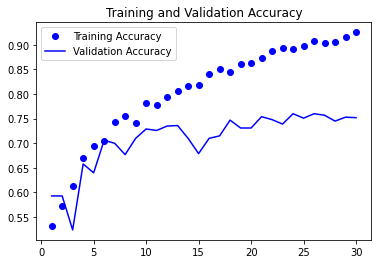

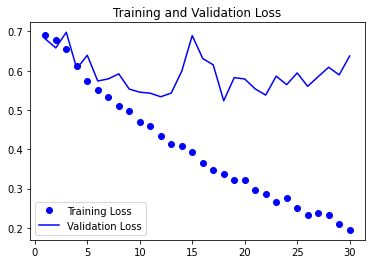

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history["acc"]
    val_acc = history.history["val_acc"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, "bo", label="Training Accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training Loss")
    plt.plot(epochs, val_loss, "b", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.show()
    
plot_history(basic_history)

## Data Augmentation

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model = create_model()
augmented_history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.


/usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 13s 121ms/step - loss: 0.6959 - acc: 0.4880 - val_loss: 0.6841 - val_acc: 0.5380
Epoch 2/100
100/100 [==============================] - 12s 119ms/step - loss: 0.6877 - acc: 0.5302 - val_loss: 0.6577 - val_acc: 0.6060
Epoch 3/100
100/100 [==============================] - 12s 119ms/step - loss: 0.6721 - acc: 0.5627 - val_loss: 0.6425 - val_acc: 0.6160
Epoch 4/100
100/100 [==============================] - 12s 120ms/step - loss: 0.6505 - acc: 0.6163 - val_loss: 0.6403 - val_acc: 0.6060
Epoch 5/100
100/100 [==============================] - 12s 120ms/step - loss: 0.6410 - acc: 0.6252 - val_loss: 0.6202 - val_acc: 0.6460
Epoch 6/100
100/100 [==============================] - 12s 121ms/step - loss: 0.6271 - acc: 0.6443 - val_loss: 0.6010 - val_acc: 0.6670
Epoch 7/100
100/100 [==============================] - 12s 120ms/step - loss: 0.6030 - acc: 0.6582 - val_loss: 0.5903 - val_acc: 0.6770
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 12s 122ms/step - loss: 0.4594 - acc: 0.7779 - val_loss: 0.4725 - val_acc: 0.7770
Epoch 62/100
100/100 [==============================] - 12s 120ms/step - loss: 0.4504 - acc: 0.7839 - val_loss: 0.4429 - val_acc: 0.7960
Epoch 63/100
100/100 [==============================] - 12s 121ms/step - loss: 0.4255 - acc: 0.7945 - val_loss: 0.5179 - val_acc: 0.7780
Epoch 64/100
100/100 [==============================] - 12s 122ms/step - loss: 0.4217 - acc: 0.8185 - val_loss: 0.4726 - val_acc: 0.7700
Epoch 65/100
100/100 [==============================] - 12s 118ms/step - loss: 0.4318 - acc: 0.8031 - val_loss: 0.4733 - val_acc: 0.7750
Epoch 66/100
100/100 [==============================] - 12s 121ms/step - loss: 0.4578 - acc: 0.7891 - val_loss: 0.4218 - val_acc: 0.8050
Epoch 67/100
100/100 [==============================] - 12s 119ms/step - loss: 0.4425 - acc: 0.7783 - val_loss: 0.4614 - val_acc: 0.7790
Epoch 68/100
100/100 [===================

In [10]:
model.save("./models/cats_and_dogs_small_2.h5")

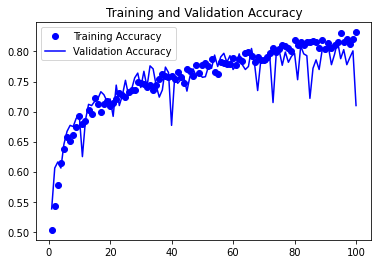

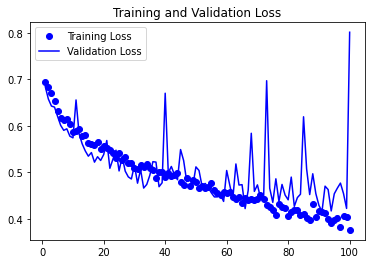

In [11]:
plot_history(augmented_history)

## Using a Pretrained ConvNet

### Feature Extraction W/O Data Augmentation

In [12]:
import os
import numpy as np

from keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

conv_base.summary()

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Epoch 1/30
100/100 [==============================] - 1s 4ms/step - loss: 0.6898 - acc: 0.5838 - val_loss: 0.4876 - val_acc: 0.7650
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.4635 - acc: 0.7862 - val_loss: 0.3785 - val_acc: 0.8610
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3716 - acc: 0.8356 - val_loss: 0.3489 - val_acc: 0.8630
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3325 - acc: 0.8629 - val_loss: 0.3020 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3126 - acc: 0.8611 - val_loss: 0.2861 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2871 - acc: 0.8817 - val_loss: 0.2742 - val_acc: 0.8910
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2741 - acc: 0.8842 - val_loss: 0.2686 - val_acc: 0.8940
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

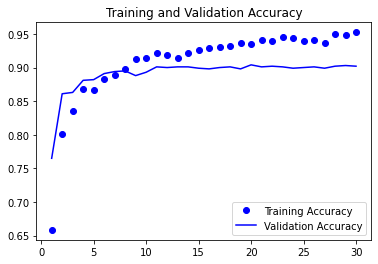

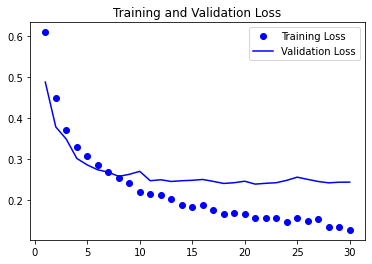

In [13]:
model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss="binary_crossentropy",
    metrics=["acc"]
)

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

plot_history(history)

In [14]:
model.save("./models/cats_and_dogs_small_3.h5")

### Feature Extraction W/ Data Augmentation

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_24 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 13s 125ms/step - loss: 0.2711 - acc: 0.9120 - val_loss: 0.1446 - val_acc: 0.9340
Epoch 2/30
100/100 [==============================] - 13s 126ms/step - loss: 0.0818 - acc: 0.969

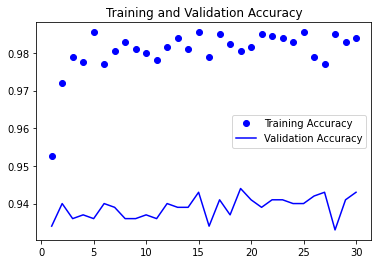

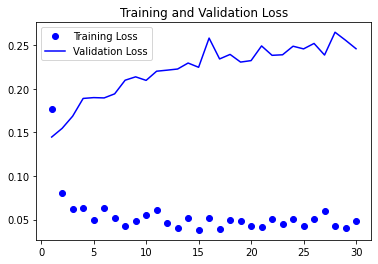

In [20]:
def create_pretrained_model():
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.RMSprop(lr=2e-5),
        metrics=["acc"]
    )
    return model

conv_base.trainable = False
model = create_pretrained_model()

model.summary()

pretrained_history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

plot_history(pretrained_history)

In [21]:
model.save("./models/cats_and_dogs_small_4.h5")

### Feature Extraction W/ Data Augmentation and Fine Tuning

In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_44 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 14s 137ms/step - loss: 0.2492 - acc: 0.8988 - val_loss: 0.1896 - val_acc: 0.9280
Epoch 2/30
100/100 [==============================] - 14s 137ms/step - loss: 0.1044 - acc: 0.9535

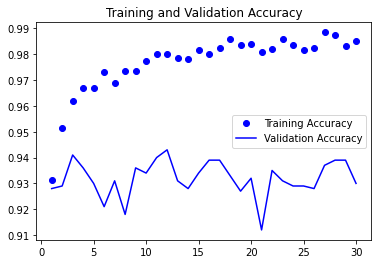

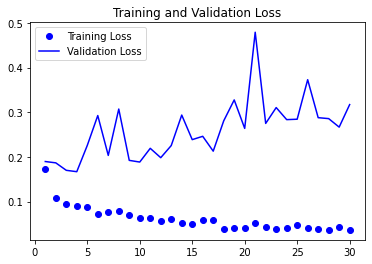

In [23]:
conv_base.trainable = True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable=True
    layer.trainable = set_trainable

    model = create_pretrained_model()

model = create_pretrained_model()

model.summary()

finetuned_history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

plot_history(finetuned_history)

In [24]:
model.save("./models/cats_and_dogs_small_5.h5")